# **데이터 기반 금융·외환 조기경보모형**
**Ⅰ. 데이터 입수 및 변환**

**Ⅱ. 모형 하이퍼파라미터 튜닝 및 평가**

**Ⅲ. 모형 학습 및 예측**

- [💾이슈노트 다운로드](./BOK_issue_note_2024-11.pdf)
- [💾코드 다운로드](./ews.py)

# Ⅰ. 데이터 입수 및 변환

## 1 데이터 입수

In [2]:
# 라이브러리 임포트
import importlib as ipl # ews.py 모듈 수정후 리로드하기 위한 라이브러리
import ews # ews.py 모듈
import pandas as pd

### 데이터셋
- `ews_nb.xlsx` 데이터
- `meta`, `data` sheet로 구성 
- `meta` sheet는 각 변수의 메타정보를 포함

In [3]:
# 메타데이터 로딩
meta = pd.read_excel('ews_nb.xlsx', header=0, index_col='Data ID', sheet_name='meta') # header=0: 첫 행이 헤더, index_col='Data ID': Data ID를 인덱스(행 이름)로 설정, sheet_name='meta': 메타데이터 시트 이름

# # dataframe의 모든 행과 열 표시
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# # 열너비 제한 해제(긴문자열 줄바꿈 되지 않도록)
# pd.set_option('display.max_colwidth', None)

# # 설정한 옵션 해제 방법
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_colwidth')
# 과제: 위 작업을 한번에 하는 함수 생성

meta

,Group1,Group2,Group3,Data Name,Unit,Freq,Delay,Feature,BIDAS ID,Data Source Desc
Data ID,,,,,,,,,,
gdp,공통,NaN,NaN,명목GDP,level,Q,3,NaN,NECOS-200U105-Q-1400,"경제활동별 GDP 및 GNI(원계열, 명목, 분기 및 연간)-분기-국내총생산(시장가..."
reserve,취약성,자금조달,대외,외환보유액,level,M,1,NaN,NECOS-732U001-M-99,외환보유액 현황-월-합계
short_ex_debt,취약성,자금조달,대외,단기대외채무,level,Q,3,NaN,NECOS-311U004-Q-A500000,대외채무-분기-1.단기
res_sdebt_neg,취약성,자금조달,대외,단기외채 비율,%,Q,3,Y,NaN,NaN
bank_capital,취약성,자금조달,은행,일반은행 자본 합계,level,M,1,NaN,FAIRS-AA004-AA1100S-PZ00000-A-1-6,일반은행 자본
...,...,...,...,...,...,...,...,...,...,...
epu_tp,트리거,심리,NaN,US Categorical Economic Policy Uncertainty Tra...,Index,M,1,NaN,BBG-BBG-EPUCTRAD_Index,NaN
epu_tp_pchg,트리거,심리,NaN,US Categorical Economic Policy Uncertainty Tra...,%,M,1,Y,NaN,NaN
esi,트리거,심리,NaN,경제심리지수(순환변동치),Index,M,1,NaN,NECOS-513U001-M-E2000,NaN


In [4]:
# 변수 정보를 저장할 딕셔너리
features = {'id': [], 'type': [], 'group': [], 'name': []} 
for var, row in meta[meta['Feature'] == 'Y'].iterrows(): # meta['Feature'] == 'Y': Feature가 Y인 행만 추출해서 forloop, iterrows는 (index, row) 형태로 반환
    features['id'].append(var)
    features['type'].append(row['Group1'])
    features['group'].append(row['Group2'])
    features['name'].append(row['Data Name'])

### ews 모듈의 Bidas 클래스
- `Bidas` 클래스를 이용해 분석에 사용할 `table` 만들기

In [116]:
# Bidas 데이터  입수
bidas_ids = meta['BIDAS ID'].dropna().values # meta['BIDAS ID'].dropna(): BIDAS ID가 비어있지 않은 행만 추출, .values: 추출한 행을 리스트로 변환
#api_headers = {'user': '2320495', 'node': 'TCAA20200504'}
#bidas = ews.Bidas('API', api_headers=api_headers) # 내부망에서 BIDAS 데이터 입수
bidas = ews.Bidas(source_type='Excel', file_name='ews_nb.xlsx', file_sheet='data') # 로컬 엑셀파일에서 BIDAS 데이터 입수

range_from = '1997-07-01'
range_to = '2025-05-31'
table = bidas.get_table(bidas_ids, 'M', range_from, range_to)

table

,NECOS-200U105-Q-1400,NECOS-732U001-M-99,NECOS-311U004-Q-A500000,FAIRS-AA004-AA1100S-PZ00000-A-1-6,FAIRS-AA004-AA1100S-CZ00000-A-1-6,NECOS-104U015-M-BDAA1,NECOS-104U016-M-BDCA1,FAIRS-AE010-AE0000S-C30000000-B-1-6,FAIRS-AE010-AE0000S-C10000000-B-1-6,NECOS-111U007-M-1000000,...,NECOS-701U002-D-1020101,BBG-BBG-CSI_A_Index,FRED-33446-CPFF,NECOS-705U003-D-3020101,BBG-BBG-VIX_Index,BBG-BBG-MOVE_Index,BBG-BBG-EPUCCUSM_Index,BBG-BBG-EPUCTRAD_Index,NECOS-513U001-M-E2000,NECOS-521U001-M-A001
period,,,,,,,,,,,,,,,,,,,,,
1997-07,143600.7,33672625.0,74377.6,25394390.0,3.754876e+08,183995.2,199051.8,NaN,NaN,523144.4,...,5.557391,NaN,-0.054091,7990.647727,20.529091,83.362609,73.89,89.94,NaN,NaN
1997-08,143600.7,31140457.0,74377.6,25612530.0,3.783529e+08,188860.1,202260.4,NaN,NaN,527075.3,...,5.553810,NaN,-0.050952,7948.427143,23.084762,86.962381,63.81,134.54,NaN,NaN
1997-09,143600.7,30425700.0,74377.6,28656490.0,4.207066e+08,192581.0,203653.3,NaN,NaN,530189.7,...,5.584545,NaN,-0.080952,7866.583333,23.812381,85.055000,61.16,114.99,NaN,NaN
1997-10,151869.7,30509096.0,58370.6,29246171.0,4.296012e+08,193636.9,207585.4,NaN,NaN,535656.2,...,5.518261,NaN,0.023636,7875.811304,23.870870,95.958696,83.65,100.84,NaN,NaN
1997-11,151869.7,24404306.0,58370.6,28972738.0,4.543359e+08,195519.5,208789.0,NaN,NaN,540665.4,...,5.546500,NaN,0.088333,7677.350526,32.206111,94.097500,78.39,180.92,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01,NaN,411014873.0,149328.4,171864855.0,2.569245e+09,2073334.0,2398711.0,14309301.0,119610772.0,3795820.1,...,4.330000,0.756190,-0.000833,43524.349000,16.763636,95.120000,167.39,1725.71,89.5,99.32
2025-02,NaN,409210148.0,NaN,172817459.0,2.561869e+09,2098313.7,2407181.5,14277934.0,118060346.0,3872799.2,...,4.330000,0.778947,0.006667,44209.310000,16.968000,90.788421,228.62,2583.90,89.0,99.85
2025-03,NaN,409659446.0,NaN,167557042.0,2.576754e+09,2124707.2,2411185.4,14219034.0,117181721.0,3849618.8,...,4.330000,0.866667,-0.039231,42092.129048,21.841429,100.864762,297.08,5912.11,88.6,93.73


#### 변수 이름(column)을 별칭(aliases)로 변경

In [117]:
aliases = {bidas_id: alias for alias, bidas_id in meta['BIDAS ID'].dropna().items()} # dictionary comprehension, meta['BIDAS ID'].dropna(): BIDAS ID가 비어있지 않은 행만 추출, .items(): 추출한 행을 키-값 쌍의 튜플로 변환
table.rename(columns=aliases, inplace=True) # .rename(): 열 이름 변경, inplace=True: 원본 데이터프레임 수정

table

,gdp,reserve,short_ex_debt,bank_capital,bank_asset,bank_dep,bank_loan,sbank_capital,sbank_asset,nbank_rc,...,ffr,us_cds_diff,us_cps_diff,dow,vix,move,epu,epu_tp,esi,nsi
period,,,,,,,,,,,,,,,,,,,,,
1997-07,143600.7,33672625.0,74377.6,25394390.0,3.754876e+08,183995.2,199051.8,NaN,NaN,523144.4,...,5.557391,NaN,-0.054091,7990.647727,20.529091,83.362609,73.89,89.94,NaN,NaN
1997-08,143600.7,31140457.0,74377.6,25612530.0,3.783529e+08,188860.1,202260.4,NaN,NaN,527075.3,...,5.553810,NaN,-0.050952,7948.427143,23.084762,86.962381,63.81,134.54,NaN,NaN
1997-09,143600.7,30425700.0,74377.6,28656490.0,4.207066e+08,192581.0,203653.3,NaN,NaN,530189.7,...,5.584545,NaN,-0.080952,7866.583333,23.812381,85.055000,61.16,114.99,NaN,NaN
1997-10,151869.7,30509096.0,58370.6,29246171.0,4.296012e+08,193636.9,207585.4,NaN,NaN,535656.2,...,5.518261,NaN,0.023636,7875.811304,23.870870,95.958696,83.65,100.84,NaN,NaN
1997-11,151869.7,24404306.0,58370.6,28972738.0,4.543359e+08,195519.5,208789.0,NaN,NaN,540665.4,...,5.546500,NaN,0.088333,7677.350526,32.206111,94.097500,78.39,180.92,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01,NaN,411014873.0,149328.4,171864855.0,2.569245e+09,2073334.0,2398711.0,14309301.0,119610772.0,3795820.1,...,4.330000,0.756190,-0.000833,43524.349000,16.763636,95.120000,167.39,1725.71,89.5,99.32
2025-02,NaN,409210148.0,NaN,172817459.0,2.561869e+09,2098313.7,2407181.5,14277934.0,118060346.0,3872799.2,...,4.330000,0.778947,0.006667,44209.310000,16.968000,90.788421,228.62,2583.90,89.0,99.85
2025-03,NaN,409659446.0,NaN,167557042.0,2.576754e+09,2124707.2,2411185.4,14219034.0,117181721.0,3849618.8,...,4.330000,0.866667,-0.039231,42092.129048,21.841429,100.864762,297.08,5912.11,88.6,93.73


In [118]:
extract_range = lambda x: [x.first_valid_index(), x.last_valid_index()] # extract_range: 시계열 데이터의 시작일과 종료일 추출, x.first_valid_index(): 시계열 데이터의 첫 번째 유효값의 인덱스, x.last_valid_index(): 시계열 데이터의 마지막 유효값의 인덱스
#table_scope = table.apply(extract_range).set_axis(['Start', 'End']).T # .apply(): 데이터프레임의 각 열에 함수 적용, .set_axis(): 인덱스 이름 변경, .T: 행과 열 전치

#table_scope

In [119]:
# 시작일이 1997-08 이후이고, 2007-10 이전인 데이터
# table_scope[('1997-07' < table_scope.loc[:, 'Start']) & (table_scope.loc[:, 'Start'] < '2021-12')] # 조건부 필터링(boolean indexing)

In [120]:
# 종료일이 2013-10이후면서, 2025-01 이전인 데이터
# table_scope[('2013-10' < table_scope.loc[:, 'End']) & (table_scope.loc[:, 'End'] < '2025-01')]

## 2 데이터 변환

In [121]:
# CFPI, 조기경보모형 관련 변수 생성
table = ews.preprocess(table) # 데이터 전처리
table_scope = table[features['id']].apply(extract_range).set_axis(['Start', 'End']).T # 데이터 범위 추출
pd.concat([meta[['Data Name', 'Freq', 'Delay']], table_scope], axis=1, join='inner') # 데이터 범위와 메타데이터 결합

,Data Name,Freq,Delay,Start,End
res_sdebt_neg,단기외채 비율,Q,3,1997-07,2025-01
bank_lev_diff,은행 레버리지,M,1,1998-07,2025-04
bank_ldr_diff,은행 예대율,M,3,1998-07,2025-03
sbank_lev_diff,저축은행 레버리지,M,1,2000-07,2025-04
nbank_ratio_diff,비은행 여수신 비율,M,3,1998-07,2025-03
hc_gdp_diff,가계신용/GDP,Q,3,1999-08,2024-10
ldr_hl,은행대출금 연체율-월-가계대출-은행전체,M,1,2002-12,2025-03
cc_gdp_diff,기업신용/GDP,Q,3,1999-08,2024-10
ldr_cp,은행대출금 연체율-월-기업대출-은행전체,M,1,2002-12,2025-03
kb_hp_pchg,주택가격,M,1,1997-10,2025-05


In [122]:
# 공표시차 적용: 실제 각 시점에 이용 가능한 정보만 활용하도록 데이터셋을 공표시차(delay)에 맞춰 조정하는 작업
for id, lag in meta[(meta['Delay'] > 0) & (meta['Feature'] == 'Y')]['Delay'].items(): # index, delay값을 튜플로 반환
    table[id] = table[id].shift(lag)
    
# 현재시점의 빈값은 가장 최근의 값으로, 시작시점의 빈값은 중위값으로 설정
table = table[range_from:range_to].ffill() # .interpolate(method='time')
table = table.fillna(table.median())

### CFPI 정의

`CFPI` = `은행부문압력지수` + `비은행부문압력지수` + 채권·주식부문압력지수 + `외환부문압력지수
- `은행부문압력지수` = KRX 은행지수 변동성 + CD스프레드
- `비은행부문압력지수` = KRX 증권, 보험 지수 변동성 + CP스프레드
- 채권·주식부문압력지수 = KOSPI 지수 변동성 - KOSPI 지수 수익률 - 기간프리미엄 - 회사채 스프레드
- 외환부문압력지수 = USD/KRW 환율 변동성

`CFPI_Bank` = `은행부문압력지수` + 채권·주식부문압력지수 + 외환부문압력지수
- `은행부문압력지수` = KRX 은행지수 변동성 + CD스프레드
- `채권·주식부문압력지수` = KOSPI 지수 변동성 - KOSPI 지수 수익률 - 기간프리미엄 - 회사채 스프레드
- 외환부문압력지수 = USD/KRW 환율 변동성

`CFPI_NonBank` = `비은행부문압력지수` + 채권·주식부문압력지수 + 외환부문압력지수
- `비은행부문압력지수` = KRX 증권, 보험 지수 변동성 + CP스프레드
- `채권·주식부문압력지수` = KOSPI 지수 변동성 - KOSPI 지수 수익률 - 기간프리미엄 - 회사채 스프레드
- 외환부문압력지수 = USD/KRW 환율 변동성

In [123]:
# cfpi 구성변수를 리스트로 정의
CFPI = ['bank_gv', 'cd_sp', 'secu_gv2', 'ins_gv2','cp_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv']

# cfpi 계산
cfpi = table[CFPI].transform(ews.Transform.scale).sum(axis=1) # scale = 평균과 표준편차로 표준화

In [139]:
k_enter = 1 # cfpi.std()*threshold 위기식별 기준
k_exit = 0.8
horizon = 6 # 조기경보모형의 예측시계
crises = ews.get_crises2(cfpi.transform(ews.Transform.scale), k_enter, k_exit, horizon, enter=2, exit=2, group_bgn_ext=3, group_end_ext=3)

gdp_growth = table['gdp_growth'].resample('Q').mean()

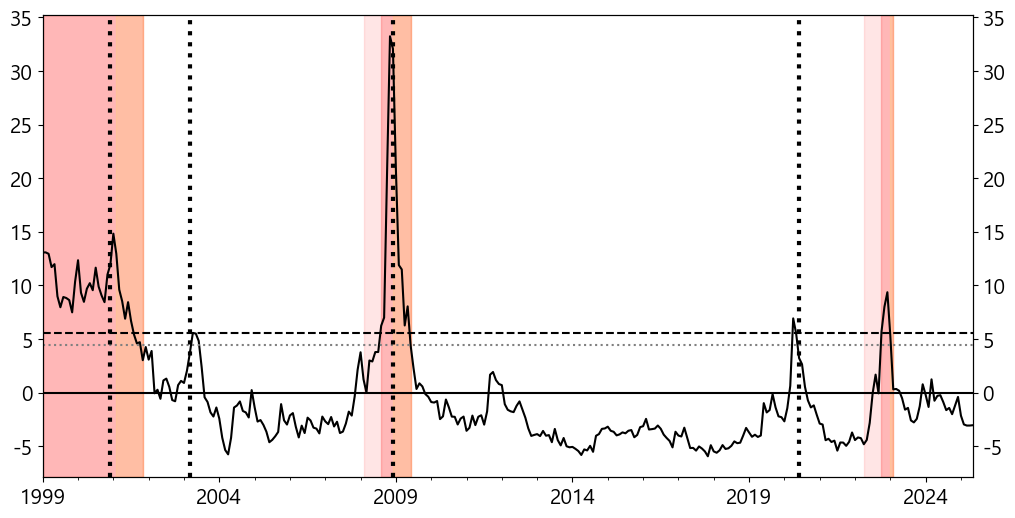

In [142]:
# cfpi
ews.plot_cfpi2(cfpi['1999-01':'2025-05'], gdp_growth, k_enter, k_exit, horizon, enter=2, exit=2, xlim=['1999-01', '2025-05'])

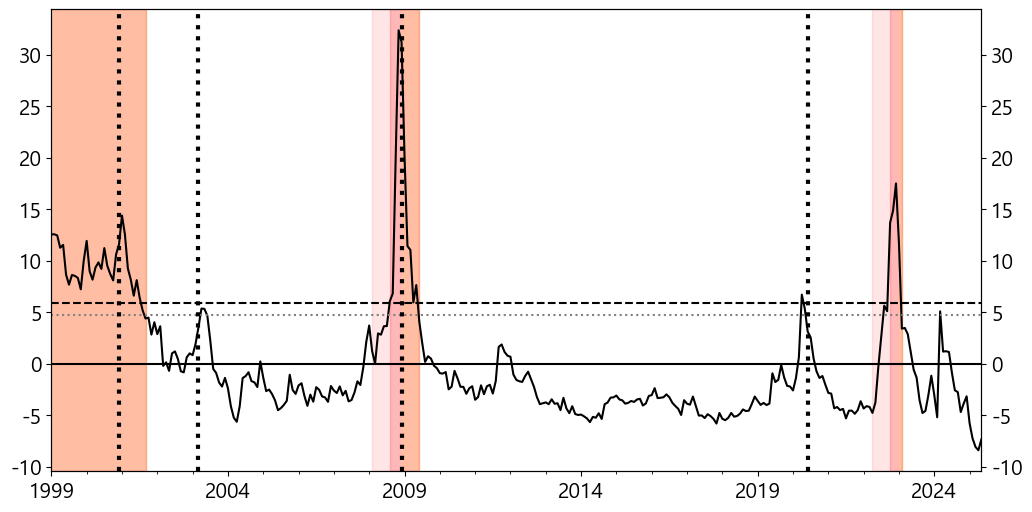

In [126]:
CFPI_OF = ['bank_gv', 'cd_sp', 'secu_gv2', 'ins_gv2', 'of_gv', 'cp_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv']
split_date = '2022-04'
cfpi_before = table[:split_date][CFPI].transform(ews.Transform.scale).sum(axis=1)
cfpi_after = table[split_date:][CFPI_OF].transform(ews.Transform.scale).sum(axis=1).drop(split_date) # .drop(split_date): split_date 시점 중복으로 제외
cfpi_of = pd.concat([cfpi_before, cfpi_after])
crises_cfpi_of = ews.get_crises2(cfpi_of, k_enter, k_exit, horizon, enter=2, exit=2, group_bgn_ext=3, group_end_ext=3)
ews.plot_cfpi2(cfpi_of, gdp_growth, k_enter, k_exit, horizon, enter=2, exit=2, xlim=['1999-01', '2025-05'])

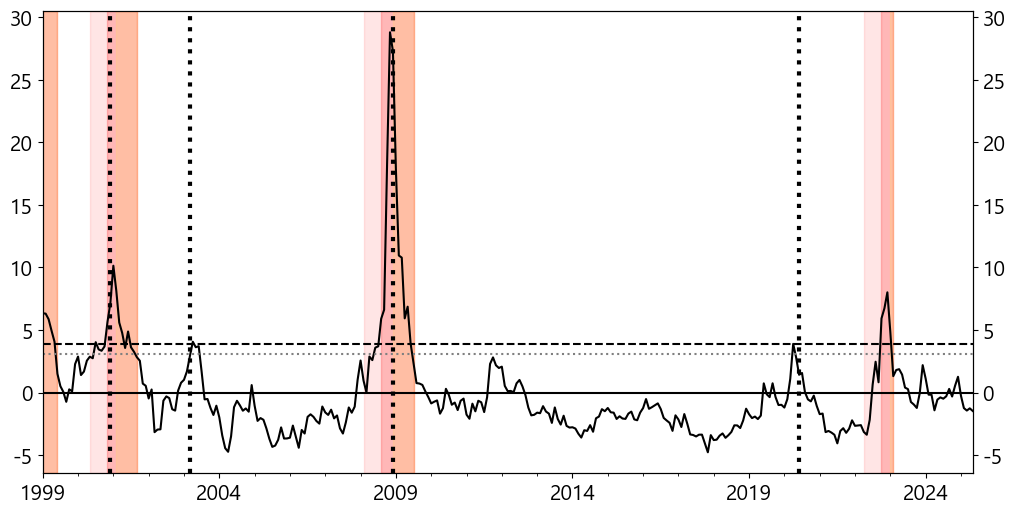

In [127]:
# Crises2
CFPI_bank = ['bank_gv', 'cd_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv'] # 기존, cfpi 구성요소

cfpi_bank = table[CFPI_bank].transform(ews.Transform.scale).sum(axis=1)
crises_bank = ews.get_crises2(cfpi_bank, k_enter, k_exit, horizon, enter=2, exit=2, group_bgn_ext=3, group_end_ext=3)

gdp_growth = table['gdp_growth'].resample('Q').mean()
ews.plot_cfpi2(cfpi_bank, gdp_growth, k_enter, k_exit, horizon, enter=2, exit=2, xlim = ['1999-01', '2025-05'], figsize=(12, 6))

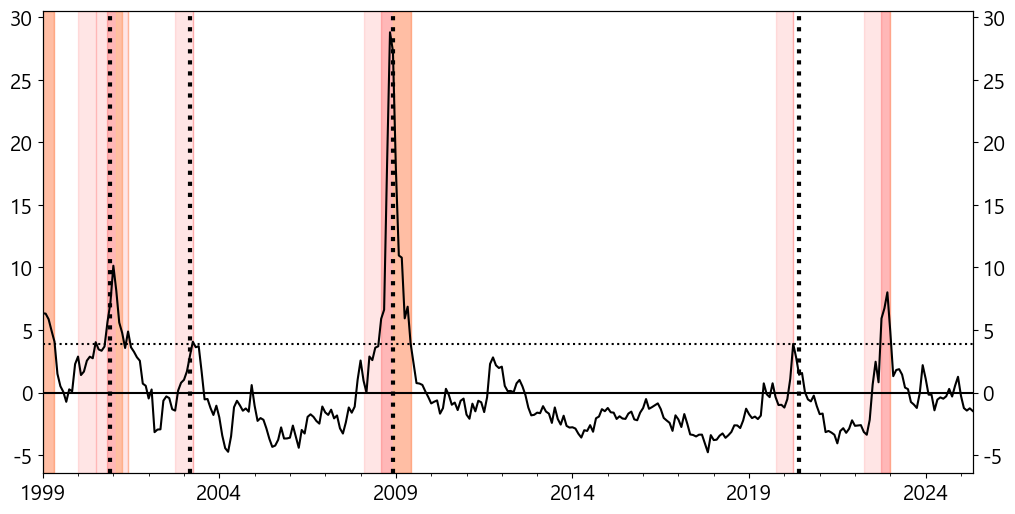

In [129]:
# Crises1
threshold = 1
CFPI_bank = ['bank_gv', 'cd_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv'] # 기존
# CFPI 지수 생성
cfpi_bank = table[CFPI_bank].transform(ews.Transform.scale).sum(axis=1)
crises_bank = ews.get_crises(cfpi_bank, threshold, horizon, group_bgn_ext=3, group_end_ext=3)

gdp_growth = table['gdp_growth'].resample('Q').mean()
ews.plot_cfpi(cfpi_bank, gdp_growth, threshold, horizon, xlim = ['1999-01', '2025-05'], figsize=(12, 6))

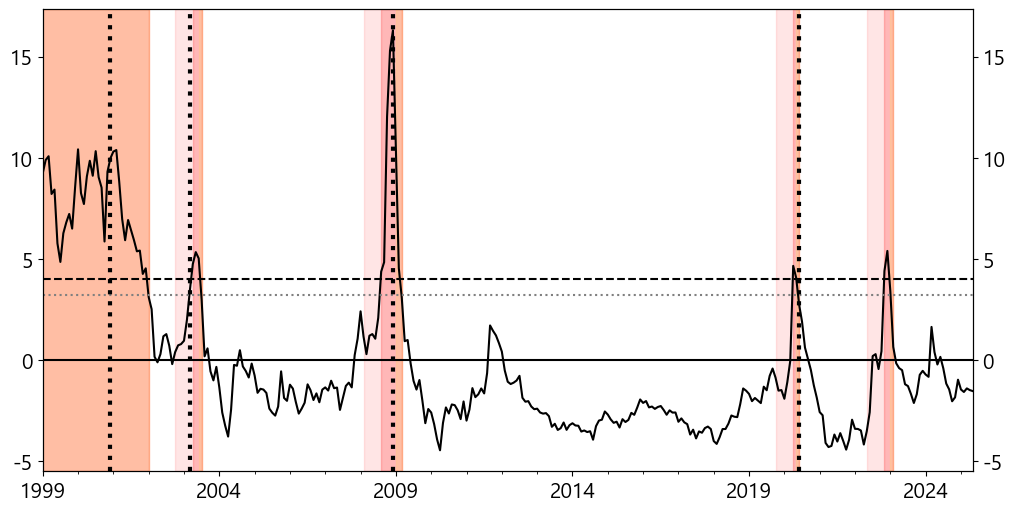

In [130]:
# 비은행, 위기 연속성 필터링, Crises2
CFPI_nbank = ['secu_gv2', 'ins_gv2', 'cp_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp']
# CFPI 지수 생성
cfpi_nbank = table[CFPI_nbank].transform(ews.Transform.scale).sum(axis=1)
crises_nbank = ews.get_crises2(cfpi_nbank, k_enter, k_exit, horizon, enter=2, exit=2, group_bgn_ext=3, group_end_ext=3)
ews.plot_cfpi2(cfpi_nbank, gdp_growth, k_enter, k_exit, horizon, enter=2, exit=2, xlim = ['1999-01', '2025-05'], figsize=(12, 6))

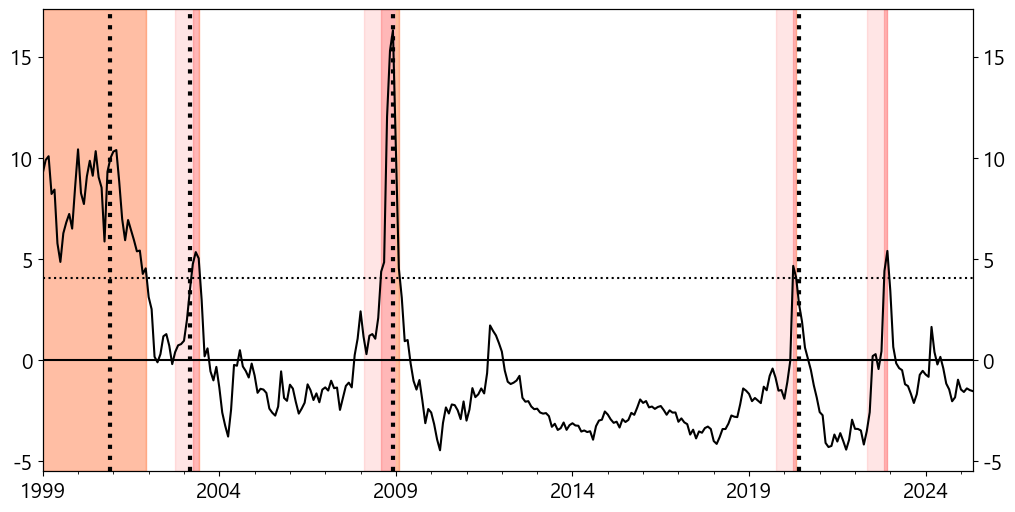

In [131]:
# 비은행, 임계치를 한번이라도 넘으면 위기, Crises1
CFPI_nbank = ['secu_gv2', 'ins_gv2', 'cp_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp']
# CFPI 지수 생성
cfpi_nbank = table[CFPI_nbank].transform(ews.Transform.scale).sum(axis=1)
crises_nbank = ews.get_crises(cfpi_nbank, threshold, horizon, group_bgn_ext=3, group_end_ext=3)
ews.plot_cfpi(cfpi_nbank, gdp_growth, threshold, horizon, xlim = ['1999-01', '2025-05'], figsize=(12, 6))

In [143]:
# cfpi 계산
# cfpi, cfpi_bank_ cfpi_nbank 구성변수를 리스트로 정의
CFPI = ['bank_gv', 'cd_sp', 'secu_gv2', 'ins_gv2','cp_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv']
CFPI_bank = ['bank_gv', 'cd_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv']
CFPI_nbank = ['secu_gv2', 'ins_gv2', 'cp_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp']

cfpi = table[CFPI].transform(ews.Transform.scale).sum(axis=1)
cfpi_bank = table[CFPI_bank].transform(ews.Transform.scale).sum(axis=1)
cfpi_nbank = table[CFPI_nbank].transform(ews.Transform.scale).sum(axis=1)

In [144]:
#FSI 불러오기
fsi = ews.Bidas(source_type='Excel', file_name='ews_nb.xlsx', file_sheet='fsi')

fsi_ids = {'fsi_bank': 'FTRA000-FSI_NEW-A04-IX-M', 
           'fsi_nbank': 'FTRA000-FSI_NEW-A05-IX-M', 
           'fsi': 'FTRA000-FSI_NEW-A06-IX-M', 
           'fsi_fin': 'FTRA000-FSI_NEW-A01-IX-M', 
           'fsi_real': 'FTRA000-FSI_NEW-A02-IX-M', 
           'fsi_ext': 'FTRA000-FSI_NEW-A03-IX-M'}
range_from = '1996-01-01'
range_to = '2025-02-01'
table_fsi = fsi.get_table(fsi_ids.values(), 'M', range_from, range_to)

# 변수 이름을 별칭으로 변경
aliases = {fsi_id: alias for alias, fsi_id in fsi_ids.items()}
table_fsi.rename(columns=aliases, inplace=True)


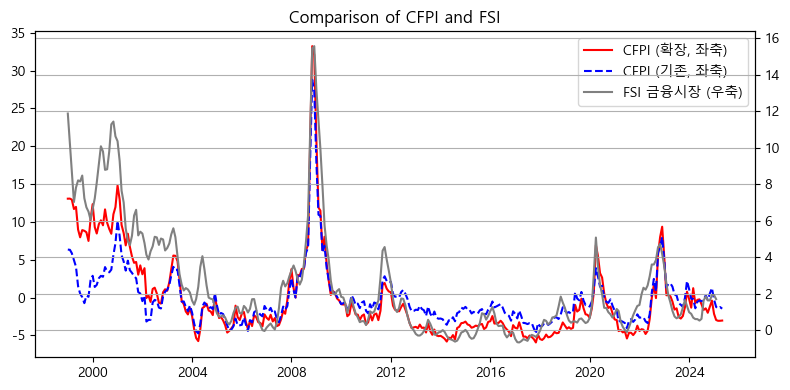

In [145]:
# CFPI와 FSI 비교
cfpi_fsi = pd.DataFrame({'cfpi': cfpi, 'cfpi_bank': cfpi_bank, 'cfpi_nbank': cfpi_nbank,
                         'fsi': table_fsi['fsi'], 'fsi_fin': table_fsi['fsi_fin'], 'fsi_bank': table_fsi['fsi_bank'],'fsi_nbank': table_fsi['fsi_nbank']})
cfpi_fsi = cfpi_fsi['1999-01':'2025-05']

import matplotlib.pyplot as plt

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(8, 4))
# Convert PeriodIndex to DatetimeIndex for better plotting
cfpi_fsi.index = cfpi_fsi.index.to_timestamp()

# Plot both CFPI indices on primary axis (left)
ax1.plot(cfpi_fsi.index, cfpi_fsi['cfpi'], color='red', label='CFPI (확장, 좌축)')
ax1.plot(cfpi_fsi.index, cfpi_fsi['cfpi_bank'], color='blue', linestyle='--', label='CFPI (기존, 좌축)')
#ax1.set_ylabel('CFPI', color='blue')
#ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary axis (right) for fsi_fin
ax2 = ax1.twinx()
ax2.plot(cfpi_fsi.index, cfpi_fsi['fsi_fin'], color='gray', label='FSI 금융시장 (우축)', linewidth=1.5)
#ax2.set_ylabel('FSI 금융시장', color='red')
#ax2.tick_params(axis='y', labelcolor='red')

# Add correlation information to title
correlation = cfpi_fsi['cfpi'].corr(cfpi_fsi['fsi_fin'])
plt.title(f'Comparison of CFPI and FSI')

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

# Save figure
fig.savefig('cfpi_fsi_comparison.png', dpi=300, bbox_inches='tight')

In [146]:
corr_cfpi_fsi = cfpi_fsi['cfpi'].corr(cfpi_fsi['fsi_fin'])
corr_cfpibank_fsi = cfpi_fsi['cfpi_bank'].corr(cfpi_fsi['fsi_fin'])
corr_cfpinbank_fsi = cfpi_fsi['cfpi_nbank'].corr(cfpi_fsi['fsi_fin'])
print(f"Correlation between CFPI and FSI 금융시장: {corr_cfpi_fsi:.4f}")
print(f"Correlation between CFPI_bank and FSI 금융시장: {corr_cfpibank_fsi:.4f}")
print(f"Correlation between CFPI_nbank and FSI 금융시장: {corr_cfpinbank_fsi:.4f}")

Correlation between CFPI and FSI 금융시장: 0.9285
Correlation between CFPI_bank and FSI 금융시장: 0.7982
Correlation between CFPI_nbank and FSI 금융시장: 0.9154


In [147]:
#cfpi 및 fsi 표준화
scaled = cfpi_fsi.transform(ews.Transform.scale)
scaled.index = scaled.index.to_period('M')

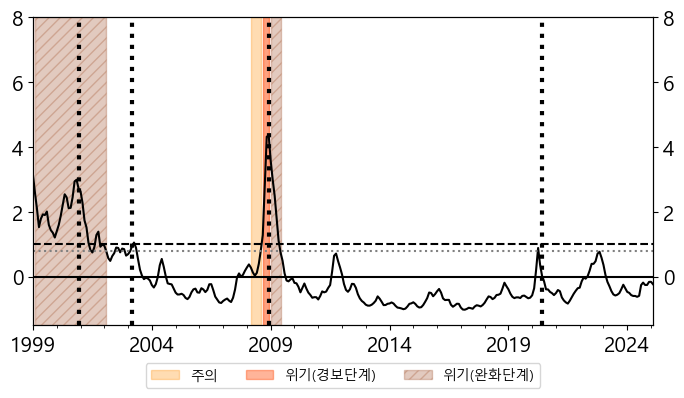

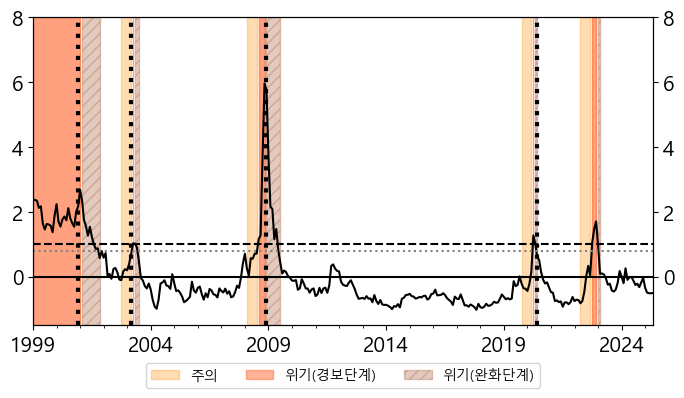

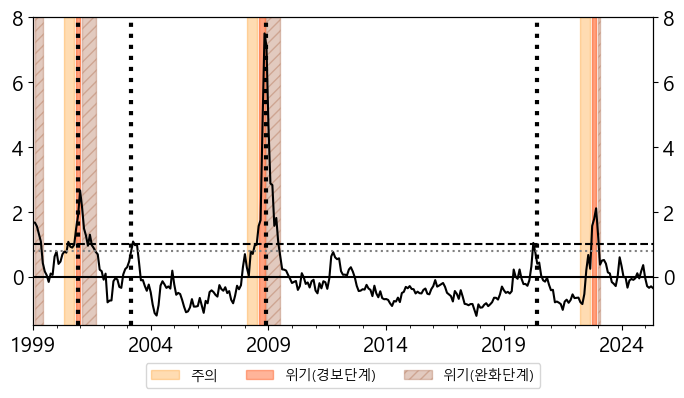

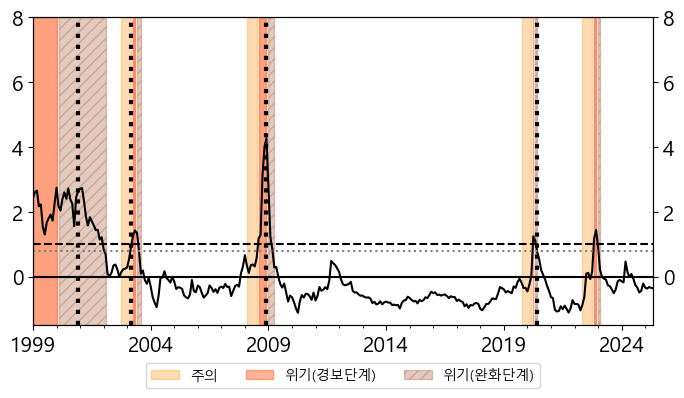

In [148]:
#crises_fsi_fin = ews.get_crises(cfpi_fsi['fsi_fin'], threshold, horizon, group_bgn_ext=0, group_end_ext=0)

k_in = 1
k_out = 0.8
horizon = 6
#fsi_fin = table_fsi['fsi_fin'].transform(ews.Transform.scale)
ews.plot_cfpi2(scaled['fsi_fin'], gdp_growth, k_in, k_out, horizon, enter=2, exit=2, xlim = ['1999-01', '2025-02'], ylim=[-1.5, 8], figsize=(8, 4))
ews.plot_cfpi2(scaled['cfpi'], gdp_growth, k_in, k_out, horizon, enter=2, exit=2, xlim = ['1999-01', '2025-05'], ylim=[-1.5, 8], figsize=(8, 4))
ews.plot_cfpi2(scaled['cfpi_bank'], gdp_growth, k_in, k_out, horizon, enter=2, exit=2, xlim = ['1999-01', '2025-05'], ylim=[-1.5, 8], figsize=(8, 4))
ews.plot_cfpi2(scaled['cfpi_nbank'], gdp_growth, k_in, k_out, horizon, enter=2, exit=2, xlim = ['1999-01', '2025-05'], ylim=[-1.5, 8], figsize=(8, 4))


In [ ]:
# 기존
threshold = 1
CFPI_bank = ['bank_gv', 'cd_sp', 'stock_gv', 'stock_ret', 'tp_sp_neg', 'cr_sp', 'er_gv'] # 기존
# CFPI 지수 생성
cfpi_bank = table[CFPI_bank].transform(ews.Transform.scale).sum(axis=1)
crises_bank = ews.get_crises(cfpi_bank, threshold, horizon, group_bgn_ext=3, group_end_ext=3)

gdp_growth = table['gdp_growth'].resample('Q').mean()
ews.plot_cfpi(cfpi_bank, gdp_growth, threshold, horizon, xlim = ['1999-01', '2025-05'], figsize=(12, 6))

# Ⅱ. 모형 하이퍼파라미터 튜닝 및 평가

## 1 하이퍼파라미터 튜닝

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

tf.data.experimental.enable_debug_mode() # 디버깅 모드 활성화
tf.config.run_functions_eagerly(True) # 함수 실행 즉시 실행

In [ ]:
# 인공신경망 모델 구성
def build_NN(units, features, dropout_prob=0.5):
    model = Sequential()
    model.add(Dense(units=units, input_shape=(features,)))
    model.add(Dropout(dropout_prob))
    model.add(Dense(units=units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(units=units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# 평가 대상 모델 정의
models = {
    'SE': ews.SignalExtraction(),
    'LR': LogisticRegression(max_iter=1000),
    'Lasso': LogisticRegression(solver='liblinear', max_iter=1000, penalty='l1'),
    'Ridge': LogisticRegression(solver='saga', max_iter=1000, penalty='l2'),
    'ElasticNet': LogisticRegression(solver='saga', max_iter=1000, penalty='elasticnet', l1_ratio=0.5),
    'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', probability=True),
    'NN': KerasClassifier(model=build_NN, units=10, features=len(features['id']), verbose=0),
    'RF': RandomForestClassifier(criterion='entropy'),
    'XGB': XGBClassifier(eval_metric='logloss'),
    'ET': ExtraTreesClassifier(),
}

# 모델별 하이퍼파라미터 탐색 범위 정의
model_param_grids = {
    'SE': {'significance': [0.7, 0.75, 0.8, 0.85, 0.9]},
    'LR': {},
    'Lasso': {'C': [1, 5, 10]},
    'Ridge': {'C': [0.1, 1, 10, 20]},
    'ElasticNet': {
        'C': [0.1, 1, 5, 10],
        'l1_ratio': [0.1, 0.5, 0.9]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': [0.01, 0.1, 1],
        'kernel': ['rbf', 'linear']
    },
    'NN': {
        'units': [5, 10, 30, 50],
        'batch_size': [30],
    },
    'RF': {
        'n_estimators': [1000],
        'max_features': [3, 5, 7, 10, 15],
        'max_depth': [5, 7, 10, 12, 15, 17, 20]
    },
    'XGB': {
        'n_estimators': [1000],
        'max_depth': [3, 5],
        'gamma': [0.03, 0.1],
        'colsample_bytree': [0.4],
        'min_child_weight': [1.5, 3],
        'learning_rate': [0.1],
        'reg_alpha': [0.75],
        'reg_lambda': [0.45],
        'subsample': [0.95],
        'objective': ['binary:logistic']
    },
    'ET': {
        'n_estimators': [1000],
        'max_features': [3, 5, 7, 10, 15],
        'max_depth': [15, 20, 30, 40]
    },
}

# 하이퍼파라미터 튜닝 실행
best_params, preds = ews.run_cv(models, model_param_grids, table[features['id']], crises)

Mean: 0.10903827968640688
Median: 0.024
70th Percentile: 0.11309084354722408
90th Percentile: 0.3545785714285717


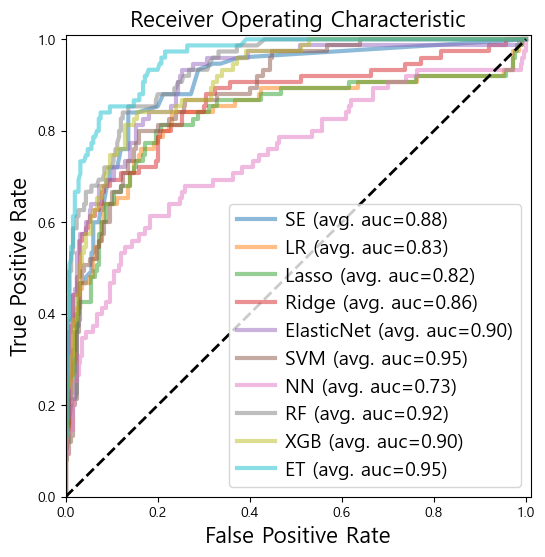

In [9]:
# (기존) 경보 지수 중위값 : 0.03, 70분위값 : 0.14, 90분위값 : 0.31
mean_value = preds['ET'].mean()
median_value = preds['ET'].median()
perc70 = preds['ET'].quantile(0.7)
perc90 = preds['ET'].quantile(0.9)
print('Mean:', mean_value)
print('Median:', median_value)
print('70th Percentile:', perc70)
print('90th Percentile:', perc90)
# ROC 곡선 및 AUC값 확인
ews.plot_roc_curve(preds)

## 2 과거 위기기간별 모형성능 검증

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier


model_params =  {
    #'SE': {'significance': 0.9},
    #'ET': {'max_depth': 30, 'max_features': 3, 'n_estimators': 1000}
    'SE': {'significance': 0.7},
    'ET': {'max_depth': 15, 'max_features': 7, 'n_estimators': 1000}
}
et_model = ExtraTreesClassifier(**model_params['ET'])
se_model = ews.SignalExtraction(**model_params['SE'])
et = ews.EarlyWarningModel(et_model)
se = ews.EarlyWarningModel(se_model)


# 반복 실행을 위한 함수 - 전역변수 사용
def train_and_predict(train_from, train_to, predict_from, predict_to):
    # 예측구간 데이터
    predict_idx = (predict_from <= table.index) & (table.index <= predict_to)
    # 학습구간 데이터 (디레버리징 기간 및 예측구간 제외)
    train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises.post_term == 0)
    train_idx &= ~predict_idx
    X_train = table[features['id']][train_idx]
    y_train = crises.ext_term[train_idx]
    X = table[features['id']][predict_idx]
    # ET는 전망+요인분해
    et.train(X_train, y_train)
    et_results, et_impacts = et.predict(X, True)
    # SE는 전망만
    se.train(X_train, y_train)
    se_results, _ = se.predict(X)
    # 예측결과 차트
    results = {'ET': et_results, 'SE': se_results}
    ews.plot_predicted(results, crises, perc70, perc90)
    # 변수별 기여도 차트
    ews.plot_decomposed(et_impacts, features['id'], features['group'])

### 글로벌 금융위기 (2007.1 ~ 2008.12)

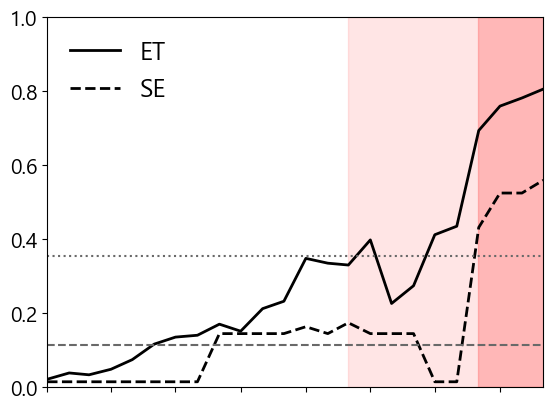

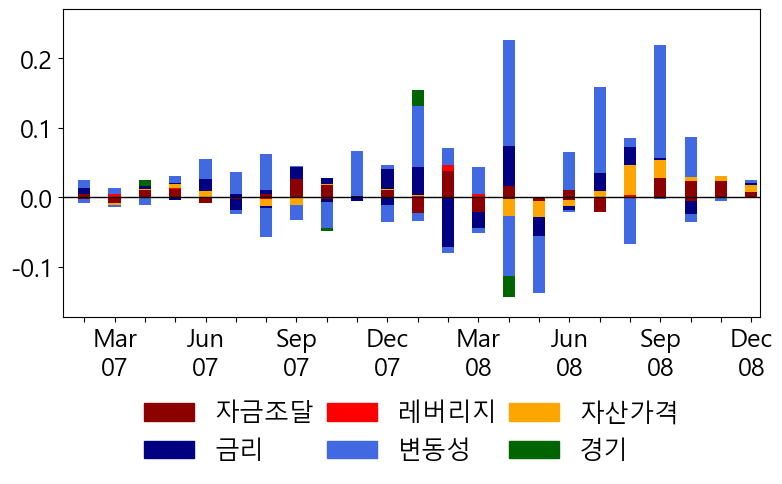

In [16]:
train_from = '1997-07'
train_to = '2006-12'
predict_from = '2007-01'
predict_to = '2008-12'

train_and_predict(train_from, train_to, predict_from, predict_to)

### 코로나 19 (2018.10 ~ 2020.5)

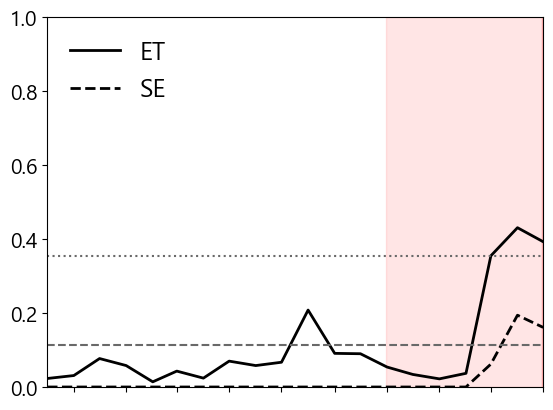

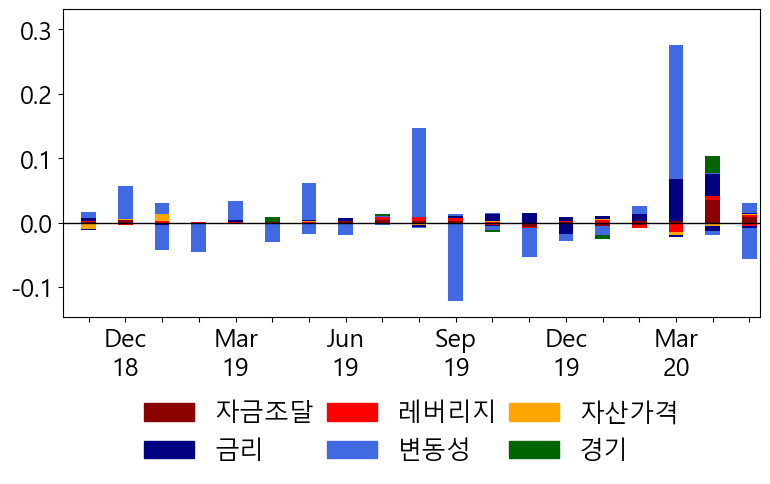

In [17]:
train_from = '1997-07'
train_to = '2018-09'
predict_from = '2018-10'
predict_to = '2020-05'

train_and_predict(train_from, train_to, predict_from, predict_to)

### 레고랜드 (2021.7 ~ 2023.1)

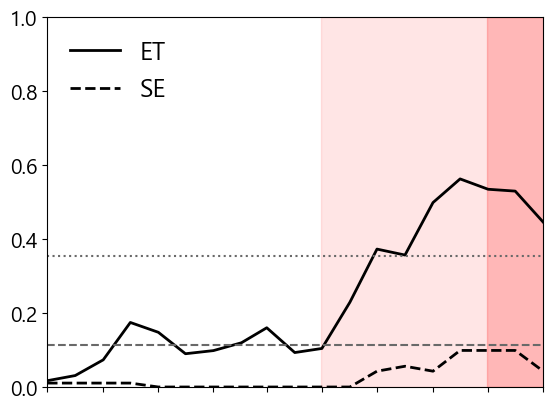

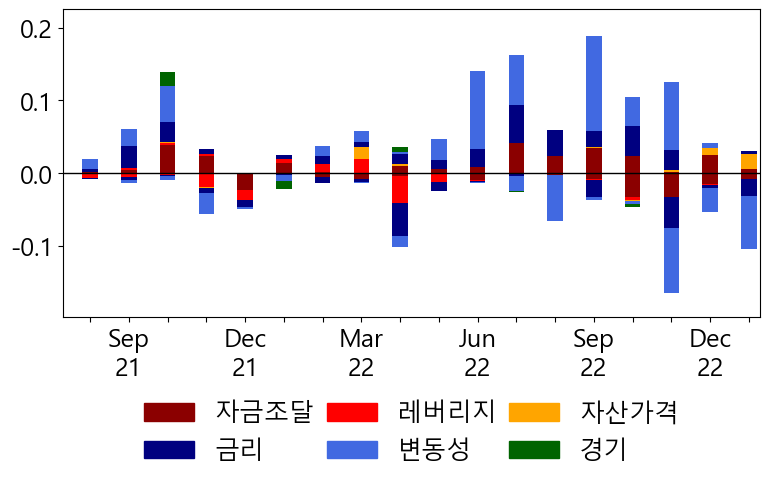

In [18]:
train_from = '1997-07'
train_to = '2021-06'
predict_from = '2021-07'
predict_to = '2023-01'

train_and_predict(train_from, train_to, predict_from, predict_to)

# Ⅲ. 모형 학습 및 예측

## 1 학습

In [19]:
from sklearn.ensemble import ExtraTreesClassifier


# 모델 초기화
model_param = {'max_depth': 30, 'max_features': 3, 'n_estimators': 1000}
model = ExtraTreesClassifier()
model.set_params(**model_param)
et = ews.EarlyWarningModel(model)

# 학습 및 결과 저장
train_from = '1997-07'
train_to = '2024-01'
model_id = '20240430'

train_idx = (train_from <= table.index) & (table.index <= train_to) & (crises.post_term == 0)
X_train = table[features['id']][train_idx]
y_train = crises.ext_term[train_idx]

et.train(X_train, y_train)
et.save(model_id)

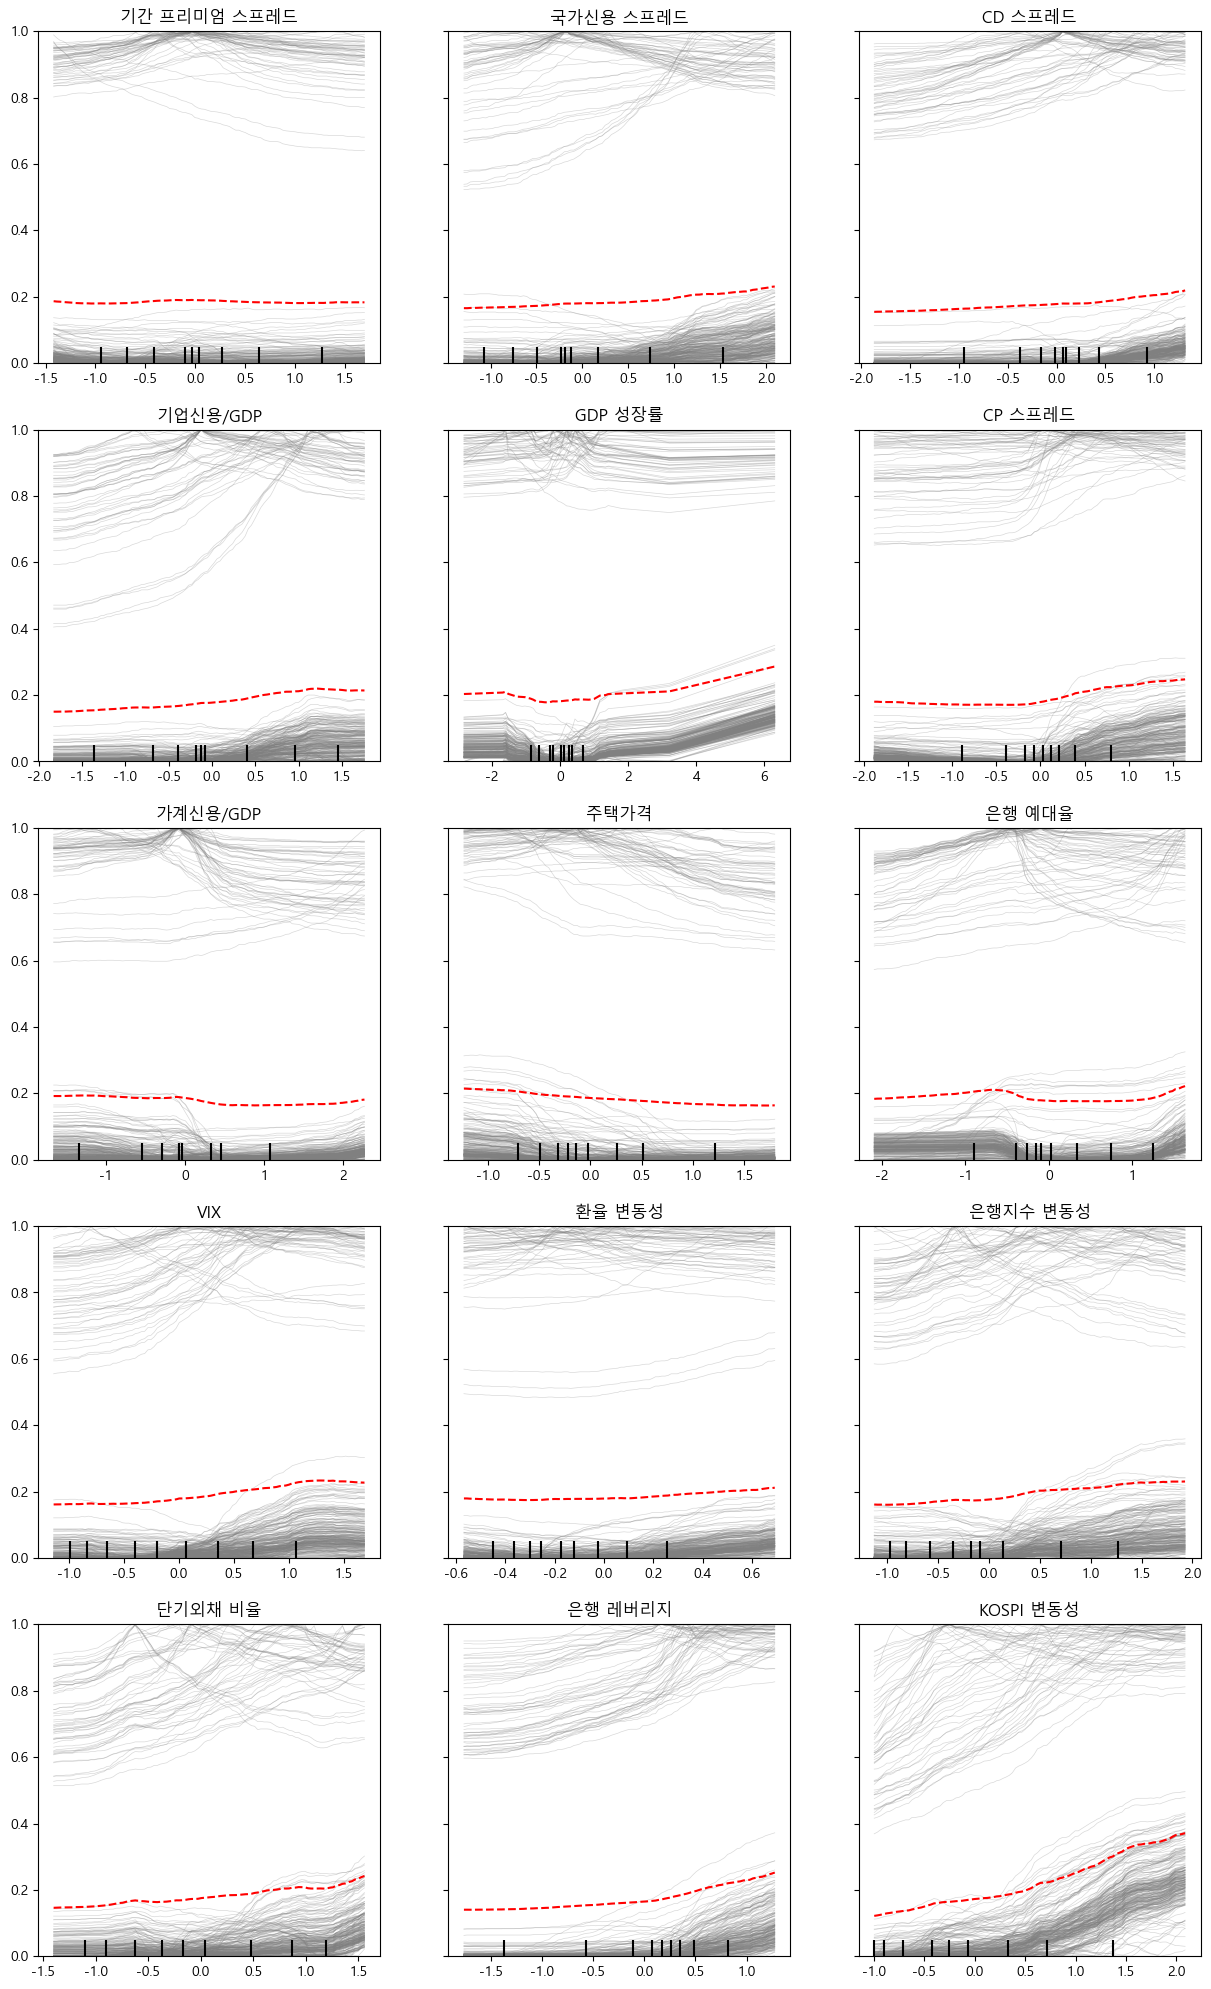

In [20]:
# pdp one-way
ews.plot_pdp_oneway(et.model, et.scale(X_train), features['name'])

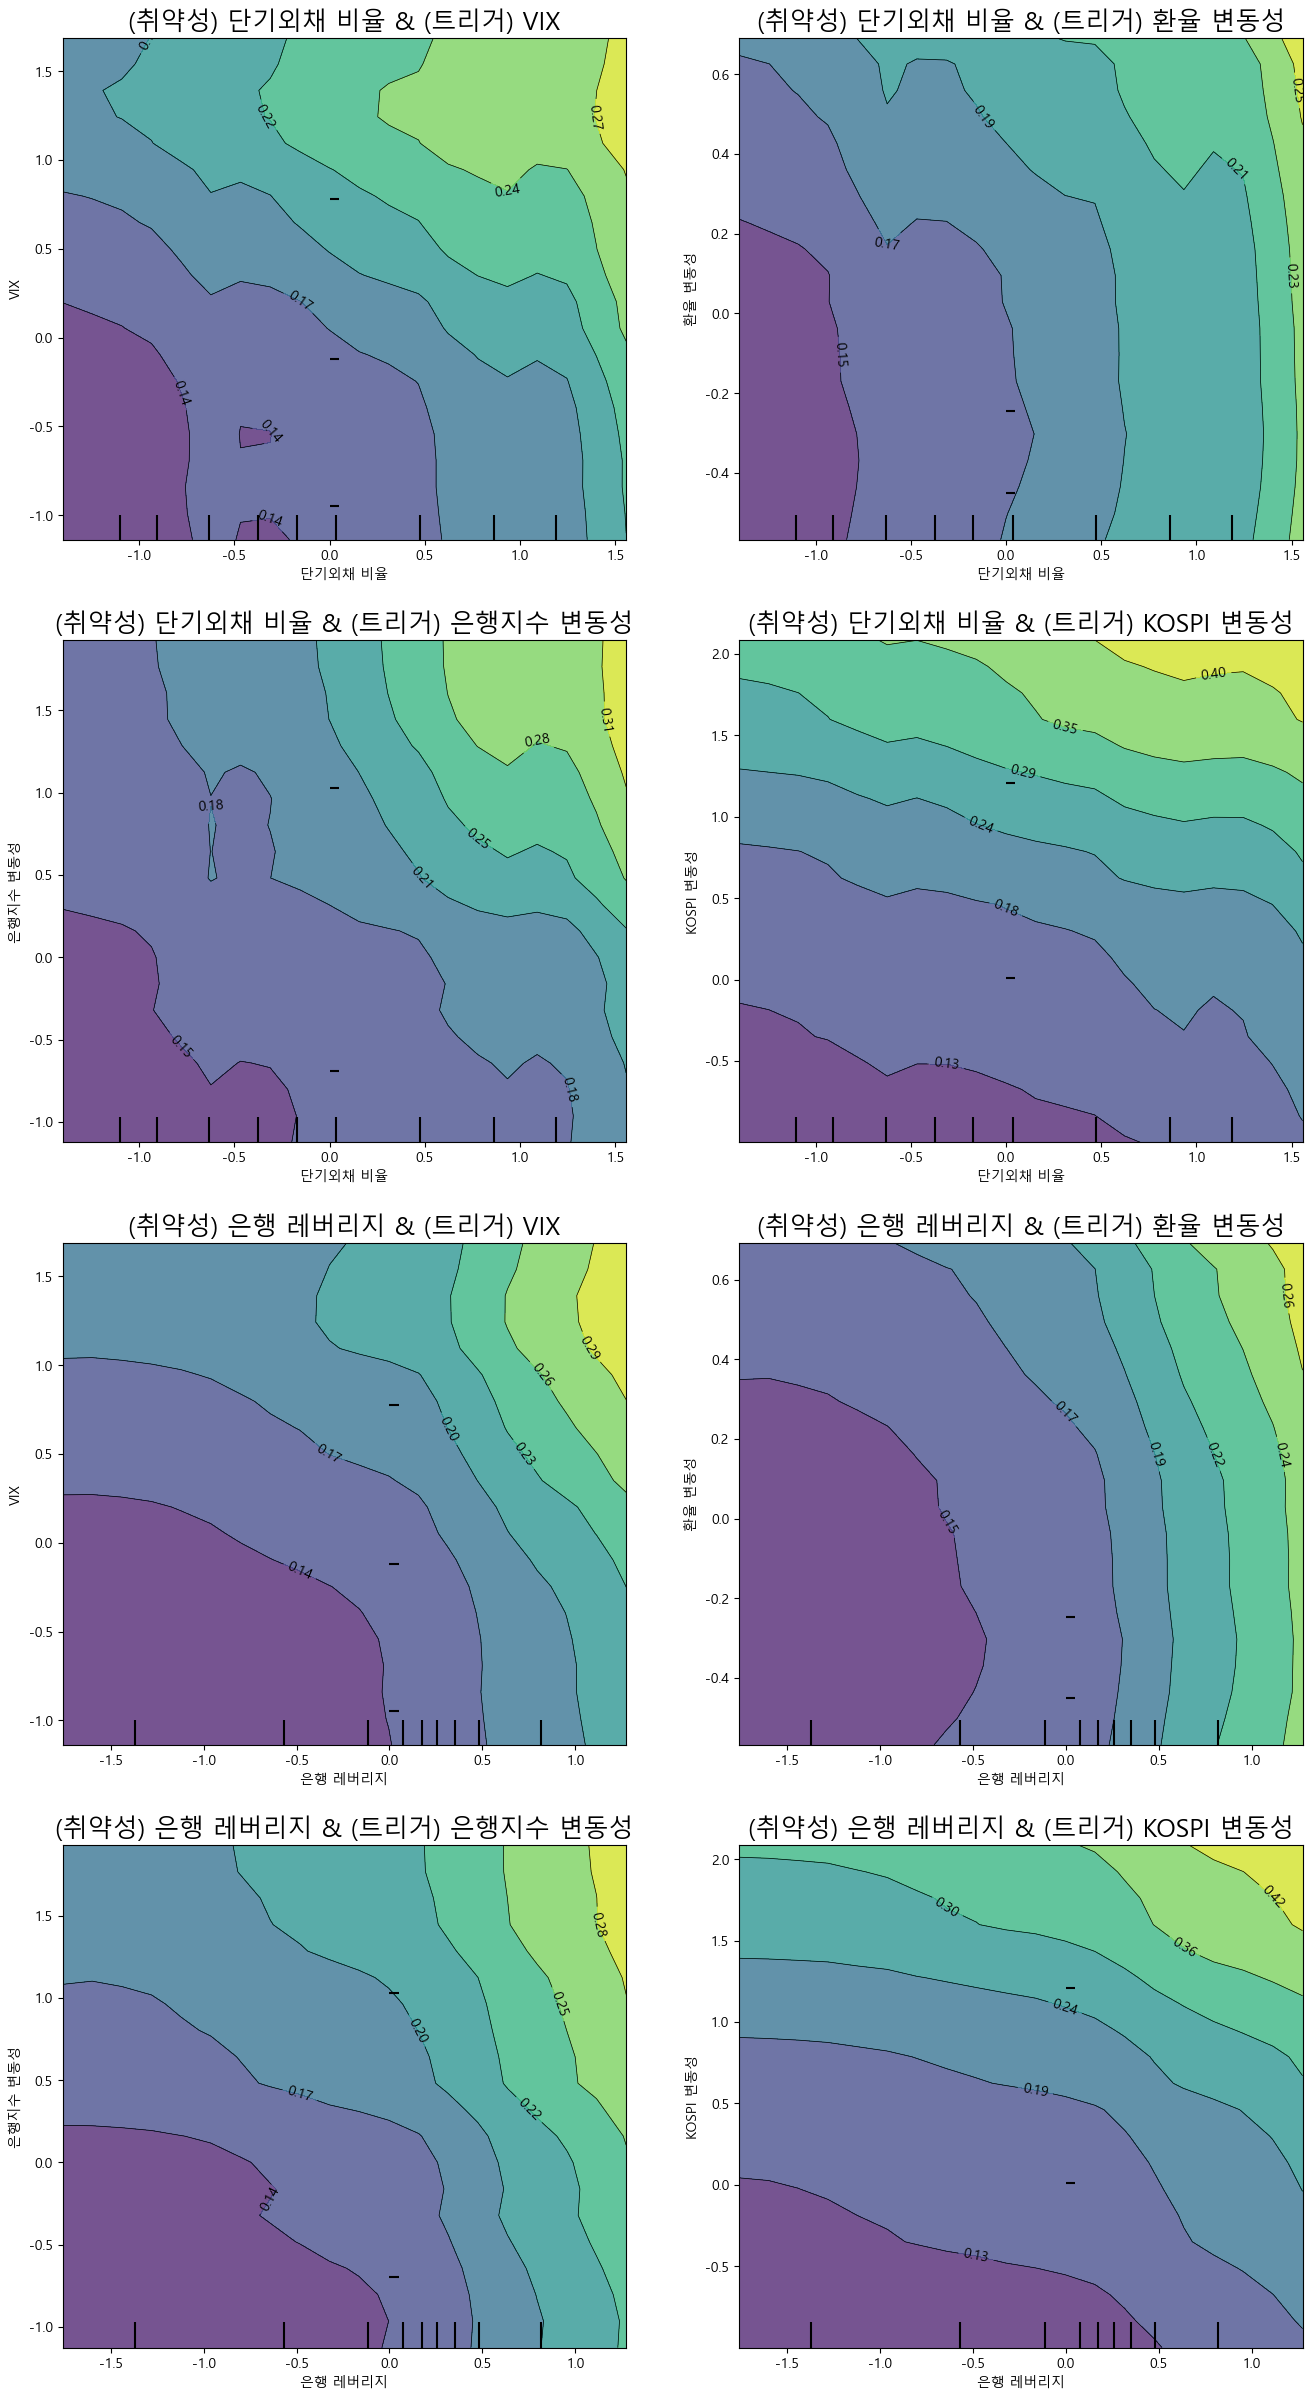

In [21]:
# pdp two-way
ews.plot_pdp_twoway(et.model, et.scale(X_train), features['name'], features['type'])

## 2 전망

In [22]:
# 모델 로딩 및 전망
model_id = '20240430'
predict_from = '2023-05'
predict_to = '2024-06'

et = ews.EarlyWarningModel()
et.load(model_id)

predict_idx = (predict_from <= table.index) & (table.index <= predict_to)
X = table[features['id']][predict_idx]

et_results, et_impacts = et.predict(X, True)
se_results, _ = et.predict(X)
# (기존) 예측값
# (5.9)
# 24.3월말 : 0.03
# 24.4월말 : 0.04
# 24.5.9일 : 0.043

# (6.10) - 국민계정 개편으로 결과가 달라졌다고 통보
# 24.3월말 : 0.02 (당초 0.03)
# 24.4월말 : 0.04 (당초 0.04)
# 24.5월말 : 0.05 (당초 0.04, 5.9일 기준)
# 24.6.10일 : 0.054

# (7.1)
# 24.5월말 : 0.05
# 24.6월말 : 0.05
# 24.7.1일 : 0.08
print(et_results[-3:])

             pred
period           
2024-04-01  0.031
2024-05-01  0.033
2024-06-01  0.042


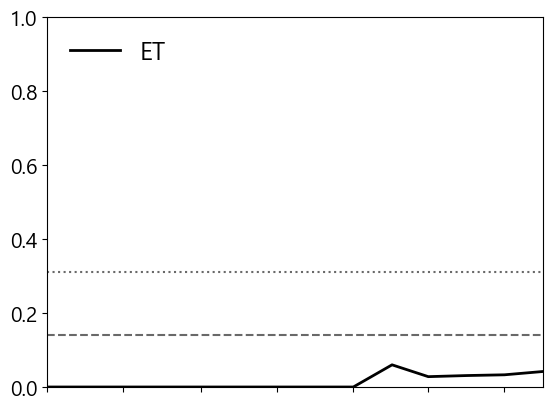

In [23]:
# 예측결과 차트
perc70 = 0.14
perc90 = 0.31
results = {'ET': et_results}
ews.plot_predicted(results, perc70=perc70, perc90=perc90)

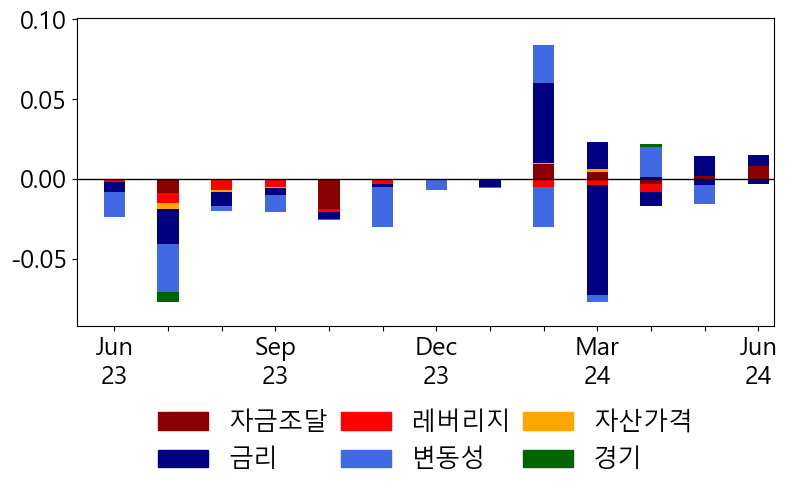

In [24]:
# 변수별 기여도 차트
ews.plot_decomposed(et_impacts, features['id'], features['group'])